In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import SensitivityAtSpecificity

In [2]:
datagen = ImageDataGenerator(rescale=1./255)
image_dim = 96
batch_size = 32

In [3]:
train_generator = datagen.flow_from_directory(
        './base_dir/train_dir/',
        target_size=(image_dim, image_dim),
        batch_size=batch_size,
        class_mode='categorical')

Found 198022 images belonging to 2 classes.


In [4]:
val_generator = datagen.flow_from_directory(
        './base_dir/val_dir/',
        target_size=(image_dim, image_dim),
        batch_size=batch_size,
        class_mode='categorical')

Found 22003 images belonging to 2 classes.


In [5]:
# Split Data(X) and target(y) from train_generator
x_train, y_train = train_generator.next()

In [16]:
# Extract x_val from test_generator to use for predicting
x, y = zip(*(val_generator[i] for i in range(len(val_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)

In [6]:
epochs = 10
input_shape = x_train.shape[1:]

In [11]:
cnn1 = Sequential()
cnn1.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
cnn1.add(Activation('relu'))
cnn1.add(MaxPooling2D(pool_size=(4, 4)))
cnn1.add(Dropout(0.25))

cnn1.add(Flatten())

cnn1.add(Dense(512))
cnn1.add(Activation('relu'))
cnn1.add(Dropout(0.5))
cnn1.add(Dense(2))
cnn1.add(Activation('softmax'))

cnn1.summary()

cnn1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
activation_3 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               9437696   
_________________________________________________________________
activation_4 (Activation)    (None, 512)              

In [12]:
# Fit the model using epochs=10
history = cnn1.fit(train_generator, validation_data=val_generator, epochs=epochs, shuffle=True, verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6189 steps, validate for 688 steps
Epoch 1/10
6189/6189 [==============================] - 199s 32ms/step - loss: 0.4693 - accuracy: 0.7884 - val_loss: 0.4026 - val_accuracy: 0.8201
Epoch 2/10
6189/6189 [==============================] - 196s 32ms/step - loss: 0.4208 - accuracy: 0.8131 - val_loss: 0.3809 - val_accuracy: 0.8332
Epoch 3/10
6189/6189 [==============================] - 194s 31ms/step - loss: 0.4033 - accuracy: 0.8233 - val_loss: 0.3914 - val_accuracy: 0.8267
Epoch 4/10
6189/6189 [==============================] - 193s 31ms/step - loss: 0.3926 - accuracy: 0.8283 - val_loss: 0.3623 - val_accuracy: 0.8433
Epoch 5/10
6189/6189 [==============================] - 193s 31ms/step - loss: 0.3839 - accuracy: 0.8341 - val_loss: 0.3736 - val_accuracy: 0.8330
Epoch 6/10
6189/6189 [==============================] - 192s 31ms/step - loss: 0.3752 - accuracy: 0.8374 - val_loss: 0.3583 - val_accuracy: 0.8419
Epoch 7/10
6189/6189 [=

In [14]:
cnn1.save('cnn_1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: cnn_1/assets


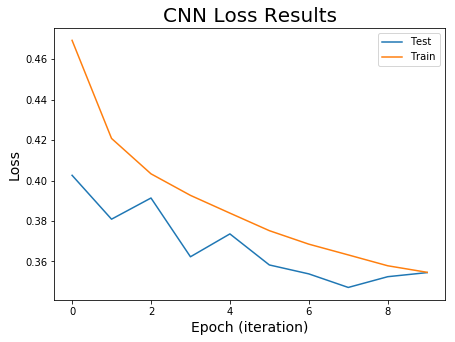

In [41]:
# plot of loss over 10 epochs
plt.figure(figsize = (7,5))
plt.title('CNN Loss Results', size=20)

plt.plot(history.history['val_loss'], label = 'Test')
plt.plot(history.history['loss'], label = 'Train')
plt.xlabel('Epoch (iteration)', size=14)
plt.ylabel('Loss', size=14)
plt.legend();

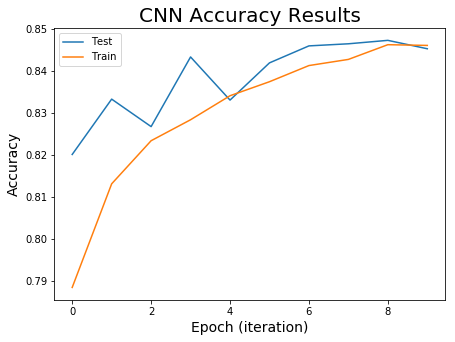

In [42]:
# plot of accuracy over 10 epochs
plt.figure(figsize = (7,5))
plt.title('CNN Accuracy Results', size=20)

plt.plot(history.history['val_accuracy'], label = 'Test')
plt.plot(history.history['accuracy'], label = 'Train')
plt.xlabel('Epoch (iteration)', size=14)
plt.ylabel('Accuracy', size=14)
plt.legend();

In [18]:
preds = cnn1.predict(x_test)
pred_proba = [i[1] for i in preds]
true_val = [i[1] for i in y_test]
pred_df = pd.DataFrame({'true_values': true_val,
                        'pred_probs':pred_proba})

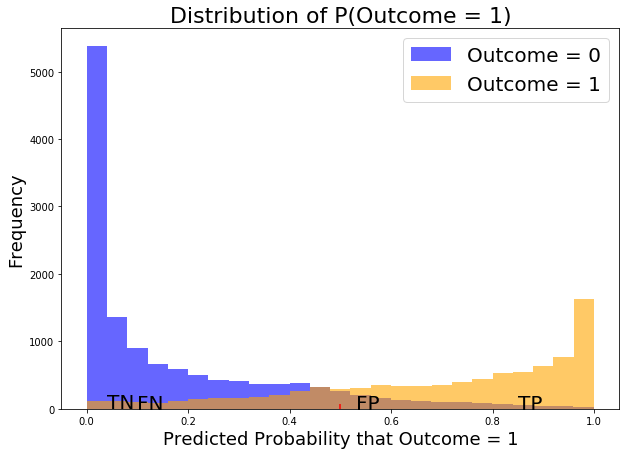

In [35]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 65,
           color = 'r',
           linestyle = '--')

# Add annotations for TN, FN, TP, FP.
plt.annotate(xy = (0.04, 15),
             s = 'TN',
             size = 20)

plt.annotate(xy = (0.1, 0),
             s = 'FN',
             size = 20)

plt.annotate(xy = (0.85, 1),
             s = 'TP',
             size = 20)

plt.annotate(xy = (0.53, 1),
             s = 'FP',
             size = 20)

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);

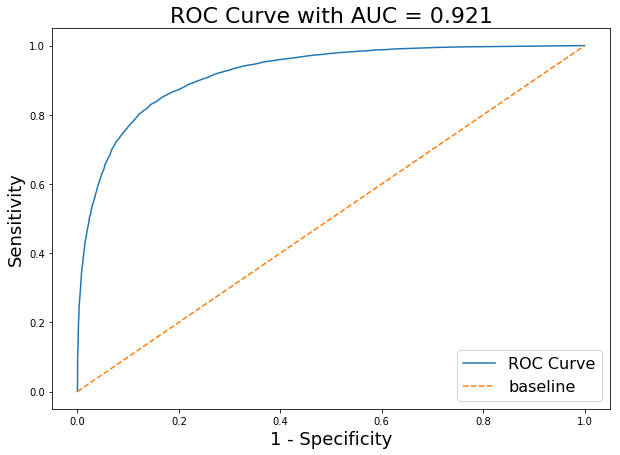

In [40]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

auc = round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)

# Label axes.
plt.title('ROC Curve with AUC = {}'.format(auc), fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [62]:
m = SensitivityAtSpecificity(0.5)

In [63]:
m.update_state(y_pred=preds, y_true = y_test)

In [64]:
m.result().numpy()

0.9783666